In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt

2024-06-15 04:53:14.665700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 04:53:14.665852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 04:53:14.838718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# JSMA Function
def jsma(model, x, y_target, theta=1.0, gamma=0.1):
    # Convert x to TensorFlow tensor
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    
    # Compute the gradient of the loss w.r.t. the input
    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model(x)
        loss = tf.reduce_sum(predictions * y_target)
    
    gradients = tape.gradient(loss, x)
    
    # Apply perturbations based on the gradients
    perturbations = theta * tf.sign(gradients)
    x_adv = x + gamma * perturbations
    
    return x_adv

In [4]:
# Define the model
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8769 - loss: 0.4370
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9654 - loss: 0.1175
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9764 - loss: 0.0781
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9843 - loss: 0.0532
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9876 - loss: 0.0420


In [5]:
# Select 5 samples
num_samples = 5
x_samples = x_test[:num_samples]
x_samples = tf.convert_to_tensor(x_samples, dtype=tf.float32)

# Target class for attack (e.g., targeting digit '2' for all examples)
y_target = np.zeros((num_samples, 10))
y_target[:, 2] = 1  # Targeting digit '2'
y_target = tf.convert_to_tensor(y_target, dtype=tf.float32)

# Apply JSMA attack
x_advs = jsma(model, x_samples, y_target)
x_advs = x_advs.numpy()
x_advs = np.clip(x_advs, 0.0, 1.0)

# Predictions for original and adversarial samples
original_predictions = model.predict(x_samples)
adversarial_predictions = model.predict(x_advs)

# Print predictions
for i in range(num_samples):
    print(f"Original Sample {i+1} Prediction: {np.argmax(original_predictions[i])}")
    print(f"Adversarial Sample {i+1} Prediction: {np.argmax(adversarial_predictions[i])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Original Sample 1 Prediction: 7
Adversarial Sample 1 Prediction: 2
Original Sample 2 Prediction: 2
Adversarial Sample 2 Prediction: 2
Original Sample 3 Prediction: 1
Adversarial Sample 3 Prediction: 2
Original Sample 4 Prediction: 0
Adversarial Sample 4 Prediction: 2
Original Sample 5 Prediction: 4
Adversarial Sample 5 Prediction: 2


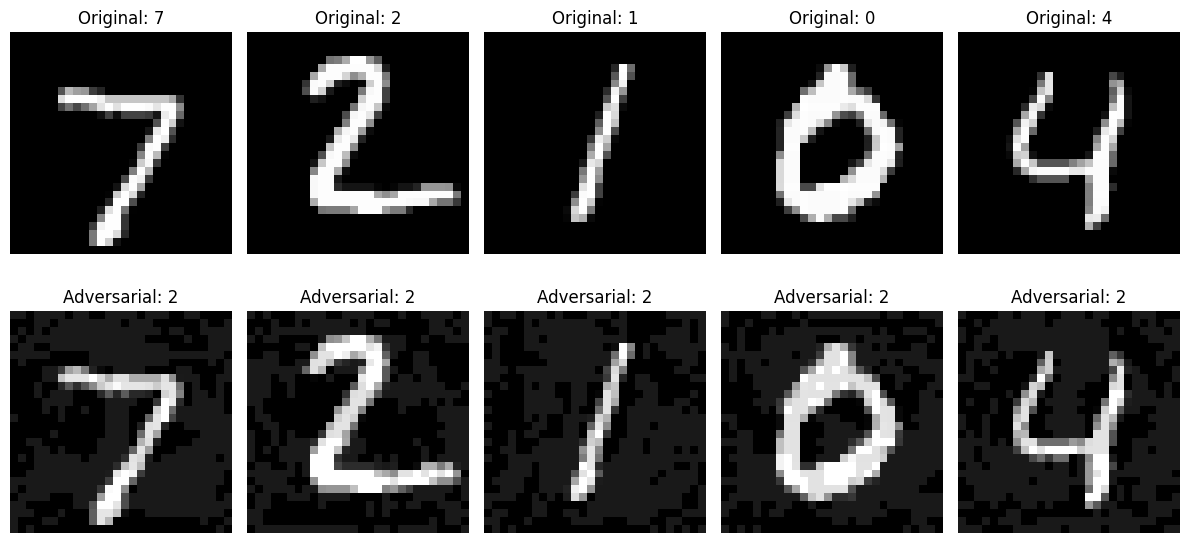

In [6]:
# Plot original and adversarial images
plt.figure(figsize=(12, 6))


for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.title(f"Original: {np.argmax(original_predictions[i])}")
    plt.imshow(x_samples[i, :, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.title(f"Adversarial: {np.argmax(adversarial_predictions[i])}")
    plt.imshow(x_advs[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Calculate accuracy
original_labels = np.argmax(original_predictions, axis=1)
adversarial_labels = np.argmax(adversarial_predictions, axis=1)
accuracy = np.mean(np.equal(original_labels, adversarial_labels)) * 100
print(f"Accuracy of JSMA attack: {accuracy:.2f}%")

Accuracy of JSMA attack: 20.00%
